# Assembled model + weather input

In this last assignment, we dissambled the walls. In the folder BLDG the different csv files can be found. The picture below shows how the dissambling was made and how the naming was chosen. 

In order to assemble the model again the folder also contains an assembly list. This list contains the information about which shared node is assigned to which thermal circuit. 

First we have the classic initialization:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dm4bem

controller = False
neglect_air_glass_capacity = True # Always true in this model
imposed_time_step = False
Δt = 1800    # s, imposed time step

Then, we can use the function bldg2TCd to assemble the thermal circuit from the csv files.  

In [6]:
folder_path = './BLDG/'

# Disassembled thermal circuits
TCd = dm4bem.bldg2TCd(folder_path,TC_auto_number=True)

# Assembled thermal circuit from assembly_lists.csv
ass_lists = pd.read_csv(folder_path + 'assembly_lists.csv')

ass_matrix = dm4bem.assemble_lists2matrix(ass_lists)
TC = dm4bem.assemble_TCd_matrix(TCd, ass_matrix)

Now, we have exactly the same thermal circuit as in assignment1 (which we used in every assignment so far). This means that we can transform the TC to a state space representation.

In [7]:
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

To verify that the assembled thermal circuit is the same as in the previous exercises, we can compare the eigenvalues or the max time step.

In [9]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As
# print(f'λ = {λ}')

# time step
Δtmax = 2 * min(-1 / λ)    # max time step for stability of Euler explicit
dm4bem.print_rounded_time('Δtmax', Δtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(Δtmax)

if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")

dm4bem.print_rounded_time('dt', dt)

# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

Δtmax = 9463 s = 2.6 h
dt = 7200 s = 2.0 h
t_settle = 493617 s = 137.1 h
duration = 496800 s = 138.0 h


We obtain the same results as before so we can continue.

To test our model for a time step, we can simulate a time step as in assignment2.

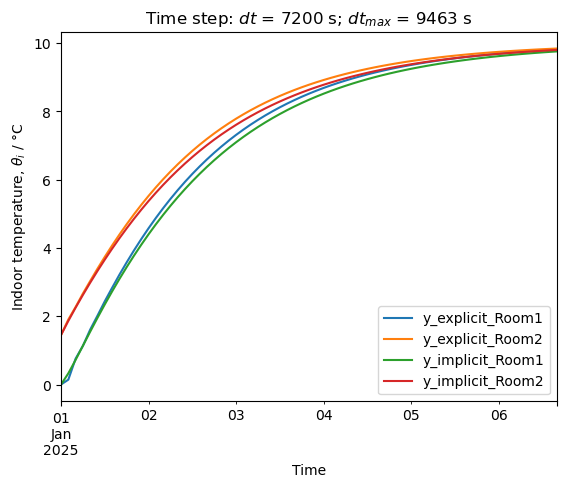

In [10]:
# Create input_data_set u with constant values
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2025-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")
 
To = 10 * np.ones(n)         # outdoor temperature 10 °C
Ti1 = 20 * np.ones(n)        # indoor temperature set point 20 °C
Ti2 = 20 * np.ones(n)        # indoor temperature set point 20 °C
Φi1 = 0 * np.ones(n)         # solar radiation absorbed by the glass
Φo2 = Φo1 = Φi2 = Φi1        # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti1': Ti1, 'To': To, 'Ti2': Ti2, 'To': To, 'Φo1': Φo1, 'Φi1': Φi1, 'Φi2': Φi2, 'Φo2': Φo2}
input_data_set = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Time integration with Euler method
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As) @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

# output for rooms
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# plot results
y = pd.concat([y_exp, y_imp], axis=1)
# Flatten the two-level column labels into a single level
y.columns = y.columns = ['y_explicit_Room1', 'y_explicit_Room2', 'y_implicit_Room1', 'y_implicit_Room2']

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

However, we can do something much more interesting: use weather data as input. We have manipulated it in assignment 3 to input and so we can now read it in immediately. Then, we resample the data with the right time step dt.

In [13]:
# Input data set
input_data_set = pd.read_csv('./MODEL/input_data_set.csv', index_col=0, parse_dates=True)
# Resample hourly data to time step dt
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')

In [14]:
# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

We apply these input values to our model without controller:

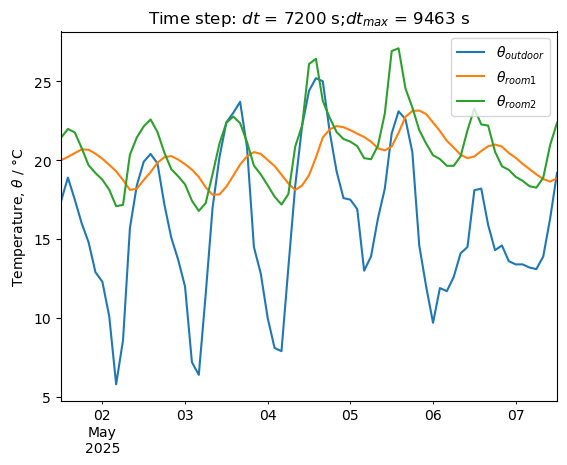

In [15]:
# initial conditions
θ0 = 20.0                   # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0

# time integration
I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As) @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    
# outputs
y = (Cs @ θ_exp.T + Ds @  u.T).T

data = pd.DataFrame({'To': input_data_set['To'],
                     'θi1': y['ow0_θ5'], 'θi2': y['ow1_θ5'],})

fig, axs = plt.subplots(1, 1)
data[['To', 'θi1', 'θi2']].plot(ax=axs,
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')
axs.legend(['$θ_{outdoor}$', '$θ_{room1}$', '$θ_{room2}$'],
              loc='upper right')


axs.set_title(f'Time step: $dt$ = {dt:.0f} s;'
                 f'$dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

We can see that the room temperatures will follow the outdoor temperature with a delay. They follow the outdoor temperature because there is no controller. The delay of room 1 is remarkable and this because it has no window. 

For assignment4_controller.py the corresponding csv files in ./BLDG_controller/ are different from the ones in ./BLDG/ because the controllers are on. This means that the room temperatures will be regulated (20°C during the day and 16°C during the night):

Δtmax = 8335 s = 2.3 h
dt = 7200 s = 2.0 h
t_settle = 174899 s = 48.6 h
duration = 176400 s = 49.0 h


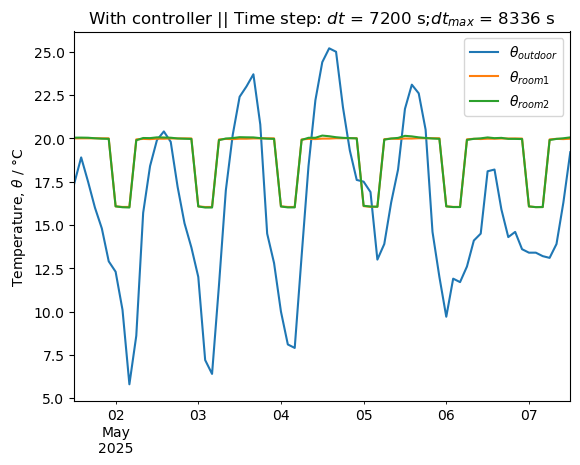

In [19]:
%run assignment4_controller.py